In [1]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset, get_datasets
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [3]:
# %%time
# data_path = '../data/'
# aug=10

# unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table4.txt',
#                                                                file_dir=data_path + 'unlrg')

# lrg_datasets = get_datasets()

In [4]:
# lrg_datasets

In [5]:
# import pickle
# pickle.dump( unlrg_data_set, open( "unlrg.p", "wb" ) )
# pickle.dump( lrg_datasets, open( "lrg.p", "wb" ) )

In [6]:
import pickle
unlrg_data_set = pickle.load( open( "unlrg.p", "rb" ) )
lrg_datasets   = pickle.load( open( "lrg.p", "rb" ) )

In [7]:
batch_size = 16 #supposedly low batch size helps fater convergence

data_loader_lrg       = data.DataLoader(lrg_datasets['full'], batch_size=128, shuffle=False)
data_loader_lrg_train = data.DataLoader(lrg_datasets['train'], batch_size=256, shuffle=True)
data_loader_lrg_test  = data.DataLoader(lrg_datasets['test'],  batch_size=256, shuffle=True)
data_loader_unlrg     = data.DataLoader(unlrg_data_set, batch_size=16,  shuffle=True)

sample = iter(data_loader_lrg).next()

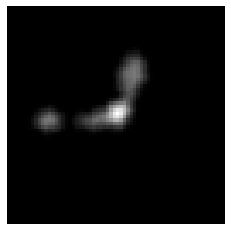

In [8]:
plt.imshow(sample[0][1][0], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
sample[1]

tensor([4, 3, 2, 2, 0, 4, 4, 1, 3, 1, 3, 3, 2, 1, 4, 4, 3, 3, 3, 0, 0, 1, 3, 0,
        4, 2, 3, 1, 1, 1, 4, 4, 4, 0, 1, 0, 3, 4, 3, 3, 4, 3, 3, 1, 1, 3, 4, 3,
        3, 5, 0, 3, 3, 0, 2, 5, 5, 3, 4, 3, 3, 1, 3, 1, 3, 0, 3, 3, 5, 0, 1, 3,
        3, 1, 0, 2, 3, 3, 3, 3, 2, 1, 0, 1, 2, 2, 3, 0, 0, 2, 1, 2, 2, 3, 1, 3,
        3, 4, 5, 0, 3, 1, 2, 2, 4, 2, 2, 1, 3, 1, 1, 3, 3, 2, 3, 3, 1, 1, 3, 2,
        1, 1, 2, 0, 4, 2, 0, 3])

In [10]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True, n_classes=2):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
        #simple classifier bit
        self.classifier = nn.Sequential(
            nn.Linear(lt_dim, n_classes),
        )
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def classify(self, x):
        y = self.classifier(x)
        return F.softmax(y)
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        y = self.classify(z)
        return d, mu, var, y

In [11]:
def train_step_vae(mode, device, data_loader, optim, epoch, loss_fun, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(data, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        d, mu, var, y = model(data)
        output = (d, mu, var)

        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        
        loss = r_loss + (beta * g_loss)
        avg_r_loss += r_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:4.4f}\tR_Loss: {:4.4f}\tDKL: {:4.4f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/len(data),
                     r_loss.item()/len(data), g_loss.item()/len(data))
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
#     print('')
    return s, avg_r_loss / batch_sum

In [12]:
def get_compact_v_extended_loss(y, target):
    target = 1*(target > 0)
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,0]
    y2[:,1] = torch.sum(y[:,1:], dim=1)
    c_loss = criterion(y2, 1*(target > 0))
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y)
    return c_loss, acc

def get_fr1_v_fr2_loss(y, target):
    tipical = (target == 2) + (target == 1)
    target = target[tipical]
    target = 1*(target == 2)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,1] / torch.sum(y[:,1:3], dim=1)
    y2[:,1] = y[:,2] / torch.sum(y[:,1:3], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_tip_v_atip_loss(y, target):
    tipical = target  > 0
    target = target[tipical]
    target = 1*(target > 2)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = torch.sum(y[:,1:3], dim=1) / torch.sum(y[:,1:], dim=1)
    y2[:,1] = torch.sum(y[:,3: ], dim=1) / torch.sum(y[:,1:], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_bent_v_irreg_loss(y, target):
    tipical = target  > 2
    target = target[tipical]
    target = 1*(target > 3)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,3 ] / torch.sum(y[:,3:], dim=1)
    y2[:,1] = torch.sum(y[:,4:], dim=1) / torch.sum(y[:,3:], dim=1)

    c_loss = criterion(y2, 1*(target > 0))
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_r_v_x_loss(y, target):
    tipical = (target == 4) + (target == 5)
    target = target[tipical]
    target = 1*(target == 5)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,4] / torch.sum(y[:,4:], dim=1)
    y2[:,1] = y[:,5] / torch.sum(y[:,4:], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def classify_step_vae(mode, device, data_loader, optim, epoch, loss_fun, criterion, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_c_loss = 0
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        d, mu, var, y = model(data)
        output = (d, mu, var)
        
        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        #Classify Loss
        c_loss, c_acc = get_compact_v_extended_loss(y, target)
        #fr1 v fr2 loss
        fr_loss, fr_acc = get_fr1_v_fr2_loss(y, target)
        #tip v atip loss
        t_loss, t_acc = get_tip_v_atip_loss(y, target)
        #bent v irreg loss
        b_loss, b_acc = get_bent_v_irreg_loss(y, target)
        #r v x loss
        rx_loss, rx_acc = get_r_v_x_loss(y, target)
        #Compund Loss
        loss = r_loss + (beta * g_loss) + (8 * c_loss + 4*t_loss + 2*fr_loss + 2*b_loss + rx_loss)
        avg_c_loss += c_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        # statistics
        running_loss += loss.item() / data.size(0)
#         running_corrects += torch.sum(preds == target.data)
#         running_inputs += len(target.data)
#         running_acc = (1.0 * running_corrects)/running_inputs
        
        s = 'Clasify Train Epoch: {:3d} ({:3.0f}%)\tC Acc: {:.4f}\tFR Acc: {:.4f}\tT Acc: {:.4f}\tB Acc: {:.4f}\tRX Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(data_loader), c_acc, fr_acc,t_acc, b_acc,rx_acc)
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    print('')
    return s

In [13]:
def test_step_vae(model, device, data_loader, loss_fun, learn_rot=False):
    model.eval()
    avg_r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            d, mu, var, y = model(data)
            output = (d, mu, var)
            # BCE Loss
            r_loss , g_loss = loss_fun(output, data)
            avg_r_loss += r_loss.item()
            
    return avg_r_loss / batch_sum

In [14]:
device = 'cuda'
epochs = 40

Clasify Train Epoch:   1 ( 99%)	C Acc: 0.5461	FR Acc: 0.6889	T Acc: 0.4699	B Acc: 0.4737	RX Acc: 0.3913
Train Epoch:   1 [139800/139800 (100%)]	Loss: 29.9649	R_Loss: 29.8484	DKL: 0.1165	AvgR 58.1340	Test Loss : 2.3834   Time : 266.50s
Clasify Train Epoch:   2 ( 99%)	C Acc: 0.6908	FR Acc: 0.6216	T Acc: 0.4697	B Acc: 0.6207	RX Acc: 0.5882
Train Epoch:   2 [139800/139800 (100%)]	Loss: 10.2923	R_Loss: 10.0478	DKL: 0.2446	AvgR 7.2271	Test Loss : 1.4840   Time : 265.71s
Clasify Train Epoch:   3 ( 99%)	C Acc: 0.7895	FR Acc: 0.5750	T Acc: 0.6267	B Acc: 0.7429	RX Acc: 0.6471
Train Epoch:   3 [139800/139800 (100%)]	Loss: 7.1567	R_Loss: 6.5561	DKL: 0.6006	AvgR 3.7189	Test Loss : 0.9487   Time : 265.11s
Clasify Train Epoch:   4 ( 99%)	C Acc: 0.8421	FR Acc: 0.6364	T Acc: 0.6250	B Acc: 0.6389	RX Acc: 0.4444
Train Epoch:   4 [139800/139800 (100%)]	Loss: 7.8350	R_Loss: 7.2888	DKL: 0.5463	AvgR 3.3502	Test Loss : 0.8258   Time : 267.22s
Clasify Train Epoch:   5 ( 99%)	C Acc: 0.9013	FR Acc: 0.5918	T Acc:

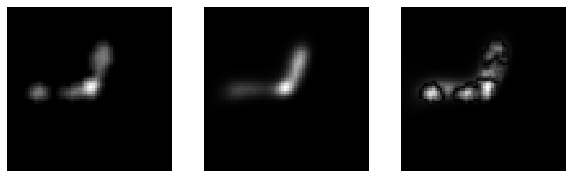

Clasify Train Epoch:  11 ( 99%)	C Acc: 0.9145	FR Acc: 0.4167	T Acc: 0.8696	B Acc: 0.6970	RX Acc: 0.5263
Train Epoch:  11 [139800/139800 (100%)]	Loss: 6.7719	R_Loss: 6.2389	DKL: 0.5330	AvgR 2.9987	Test Loss : 0.7322   Time : 263.08s
Clasify Train Epoch:  12 ( 99%)	C Acc: 0.9211	FR Acc: 0.5745	T Acc: 0.8333	B Acc: 0.6000	RX Acc: 0.4375
Train Epoch:  12 [139800/139800 (100%)]	Loss: 6.7036	R_Loss: 6.1391	DKL: 0.5645	AvgR 2.9932	Test Loss : 0.7351   Time : 262.61s
Clasify Train Epoch:  13 ( 99%)	C Acc: 0.9474	FR Acc: 0.6389	T Acc: 0.7576	B Acc: 0.6667	RX Acc: 0.7647
Train Epoch:  13 [139800/139800 (100%)]	Loss: 7.1765	R_Loss: 6.5227	DKL: 0.6537	AvgR 2.9879	Test Loss : 0.7336   Time : 264.36s
Clasify Train Epoch:  14 ( 99%)	C Acc: 0.9211	FR Acc: 0.6316	T Acc: 0.8356	B Acc: 0.8857	RX Acc: 0.6842
Train Epoch:  14 [139800/139800 (100%)]	Loss: 12.0001	R_Loss: 11.1652	DKL: 0.8349	AvgR 2.9846	Test Loss : 0.7385   Time : 264.65s
Clasify Train Epoch:  15 ( 99%)	C Acc: 0.9211	FR Acc: 0.5455	T Acc: 0.

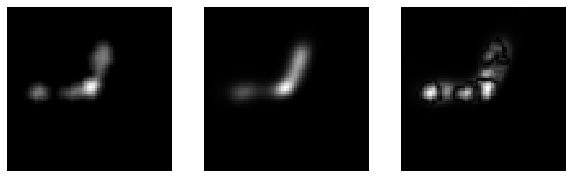

Clasify Train Epoch:  21 ( 99%)	C Acc: 0.9079	FR Acc: 0.6216	T Acc: 0.8378	B Acc: 0.7838	RX Acc: 0.7222
Train Epoch:  21 [139800/139800 (100%)]	Loss: 9.0143	R_Loss: 8.3007	DKL: 0.7136	AvgR 2.9663	Test Loss : 0.7426   Time : 265.74s
Clasify Train Epoch:  22 ( 99%)	C Acc: 0.9211	FR Acc: 0.6154	T Acc: 0.8831	B Acc: 0.6579	RX Acc: 0.4000
Train Epoch:  22 [139800/139800 (100%)]	Loss: 6.8386	R_Loss: 6.1881	DKL: 0.6505	AvgR 2.9647	Test Loss : 0.7396   Time : 265.18s
Clasify Train Epoch:  23 ( 99%)	C Acc: 0.9408	FR Acc: 0.6279	T Acc: 0.8354	B Acc: 0.6944	RX Acc: 0.6429
Train Epoch:  23 [139800/139800 (100%)]	Loss: 10.4620	R_Loss: 9.6890	DKL: 0.7730	AvgR 2.9622	Test Loss : 0.7329   Time : 262.10s
Clasify Train Epoch:  24 ( 99%)	C Acc: 0.9342	FR Acc: 0.6136	T Acc: 0.9146	B Acc: 0.6053	RX Acc: 0.5652
Train Epoch:  24 [139800/139800 (100%)]	Loss: 5.4789	R_Loss: 4.9184	DKL: 0.5605	AvgR 2.9615	Test Loss : 0.7350   Time : 263.21s
Clasify Train Epoch:  25 ( 99%)	C Acc: 0.9408	FR Acc: 0.5143	T Acc: 0.8

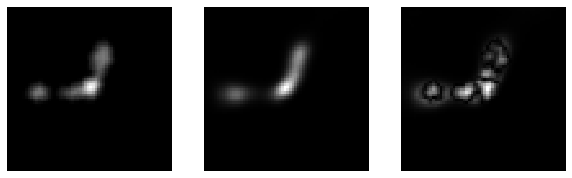

Clasify Train Epoch:  31 ( 99%)	C Acc: 0.9342	FR Acc: 0.5610	T Acc: 0.8529	B Acc: 0.8519	RX Acc: 0.5833
Train Epoch:  31 [139800/139800 (100%)]	Loss: 4.5049	R_Loss: 4.0276	DKL: 0.4773	AvgR 2.9528	Test Loss : 0.7330   Time : 263.61s
Clasify Train Epoch:  32 ( 99%)	C Acc: 0.9539	FR Acc: 0.6364	T Acc: 0.8056	B Acc: 0.7857	RX Acc: 0.7059
Train Epoch:  32 [139800/139800 (100%)]	Loss: 6.2917	R_Loss: 5.8165	DKL: 0.4752	AvgR 2.9517	Test Loss : 0.7453   Time : 264.35s
Clasify Train Epoch:  33 ( 99%)	C Acc: 0.9539	FR Acc: 0.6170	T Acc: 0.8395	B Acc: 0.7353	RX Acc: 0.7692
Train Epoch:  33 [139800/139800 (100%)]	Loss: 5.0555	R_Loss: 4.5510	DKL: 0.5045	AvgR 2.9516	Test Loss : 0.7354   Time : 266.27s
Clasify Train Epoch:  34 ( 99%)	C Acc: 0.9145	FR Acc: 0.5319	T Acc: 0.7931	B Acc: 0.7500	RX Acc: 0.8333
Train Epoch:  34 [139800/139800 (100%)]	Loss: 4.3377	R_Loss: 4.0028	DKL: 0.3350	AvgR 2.9480	Test Loss : 0.7408   Time : 263.85s
Clasify Train Epoch:  35 ( 99%)	C Acc: 0.9408	FR Acc: 0.5526	T Acc: 0.83

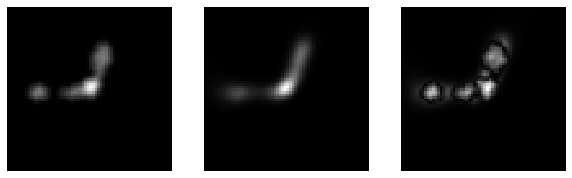

In [33]:
k = [1, 16, 'M', 32, 'M', 64, 64,'M', 64, 'M', 128, 128, 'M', 256]
model = VAE(lt_dim=8, k=k, n_classes=6).to(device)
# model = vae_models.VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1E-5)
loss_fun = VAE_Loss()
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss  = []
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    classify_step_vae(model, device, data_loader_lrg_train, optimizer, epoch, loss_fun, criterion)
#     classify_step_vae(model, device, data_loader_lrg_train, optimizer, epoch, loss_fun, criterion)
    s, l = train_step_vae(model, device, data_loader_unlrg, optimizer, epoch, loss_fun=loss_fun)
    loss = test_step_vae(model, device, data_loader_lrg, loss_fun=loss_fun)
    
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    
    sys.stdout.write('{}\tAvgR {:.4f}\tTest Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, l, loss, t))
    sys.stdout.flush()
    if epoch % 10 == 0: 
        f, ax = plt.subplots(1, 3, figsize=(10, 5))
        o = model(sample[0].to(device))
        ax[0].imshow(sample[0][1][0], cmap='gray')
        ax[1].imshow(o[0][1][0].detach().cpu(), cmap='gray')
        diff = sample[0][1][0] - o[0][1][0].detach().cpu()
        ax[2].imshow(np.abs(diff), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

In [34]:
torch.save(model, 'SimpleVAE_Class_all')

In [35]:
o = model(sample[0].to('cuda'))

In [36]:
target = Variable(sample[1], requires_grad=False).to(device)
criterion(o[1], target.to('cuda'))

tensor(2.8468, device='cuda:0', grad_fn=<NllLossBackward>)

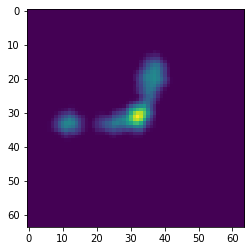

In [37]:
i = 1
plt.imshow(sample[0][i][0])

In [38]:
o = model(sample[0].to(device))

In [39]:
# o.shape

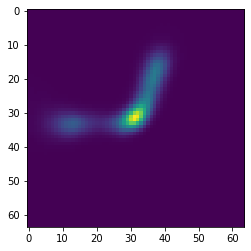

In [40]:
plt.imshow(o[0][i][0].detach().cpu())

In [41]:
# torch.save(model, 'SimpleVAE')

In [42]:
s = sample[0][i:i+1]

In [43]:
with torch.no_grad():
    e = model.encode(s.to(device))[0]

In [44]:
with torch.no_grad():
    d = model.decode(e)

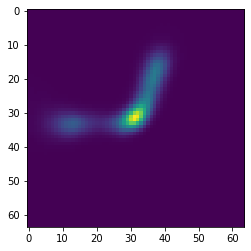

In [45]:
plt.imshow(d[0][0].cpu())

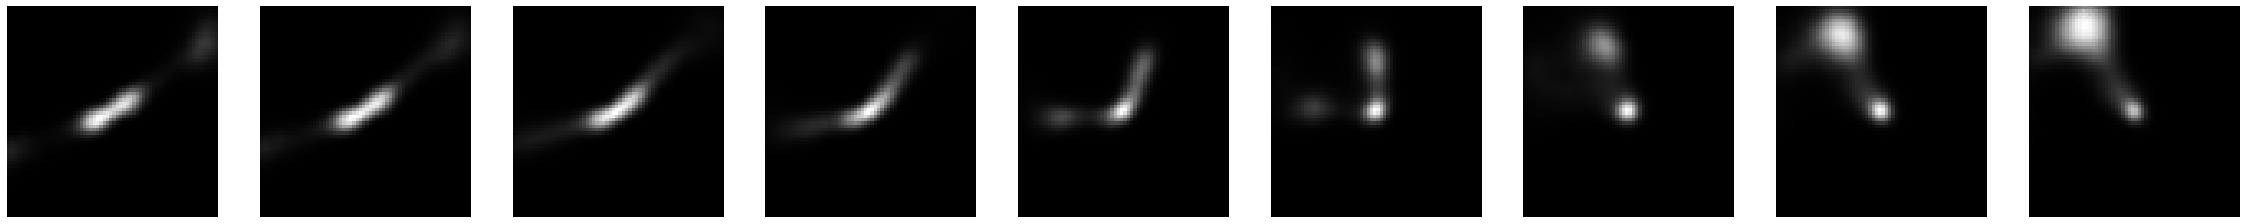

In [46]:
f, ax = plt.subplots(1, 9, figsize=(40, 20))

j = 7
for k, i in enumerate(np.arange(-2, 2.5, .5)):
    b = torch.tensor(e)
    b[0][j] = e[0][j] + 2*i
    with torch.no_grad():
        d = model.decode(b).cpu()[0][0]
    ax[k].imshow(d, cmap='gray')
    ax[k].axis('off')

In [29]:
e[0][6]

tensor(0.3967, device='cuda:0')

In [30]:
b = torch.tensor(e)

In [31]:
b[0][0] = 0

In [32]:
np.arange(-4, 4.5, 1)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])